# Example of Training a NN on ILThermo Data

Start by importing some modules:

In [2]:
import salty
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

a salty devmodel object has three components: A data_summary, scaled and centered features, and a descriptor list for those features' mean and variance.

In [81]:
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
data_range = [[206, 2295]] #the cpt dataset has one outlier ~9,000 J/mol/K
devmodel = salty.aggregate_data(['cpt'], T=T, P=P, data_ranges=data_range)
X_train, Y_train, X_test, Y_test = salty.devmodel_to_array\
    (devmodel, train_fraction=0.8)
devmodel.Data_summary

,0
Unique salts,177
Cations,"array(['CCCC[n+]1ccc(cc1)C', 'CCCCn1cc[n+](c1C..."
Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
Total datapoints,1734
cpt,207.47 - 2290.0
Temperature range (K),100.0 - 101.325
Pressure range (kPa),297.04 - 315.95


Our models were trained with keras, using a tensor flow backend. 

In [82]:
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='mean_squared_error', patience=50, verbose=1)
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=['mse'])
model.fit(X_train,Y_train,epochs=10000,verbose=False,callbacks=[early])
scores = model.evaluate(X_test, Y_test) 
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 00540: early stopping
347/347 [==============================] - 0s 439us/step
mean_squared_error: 0.73%


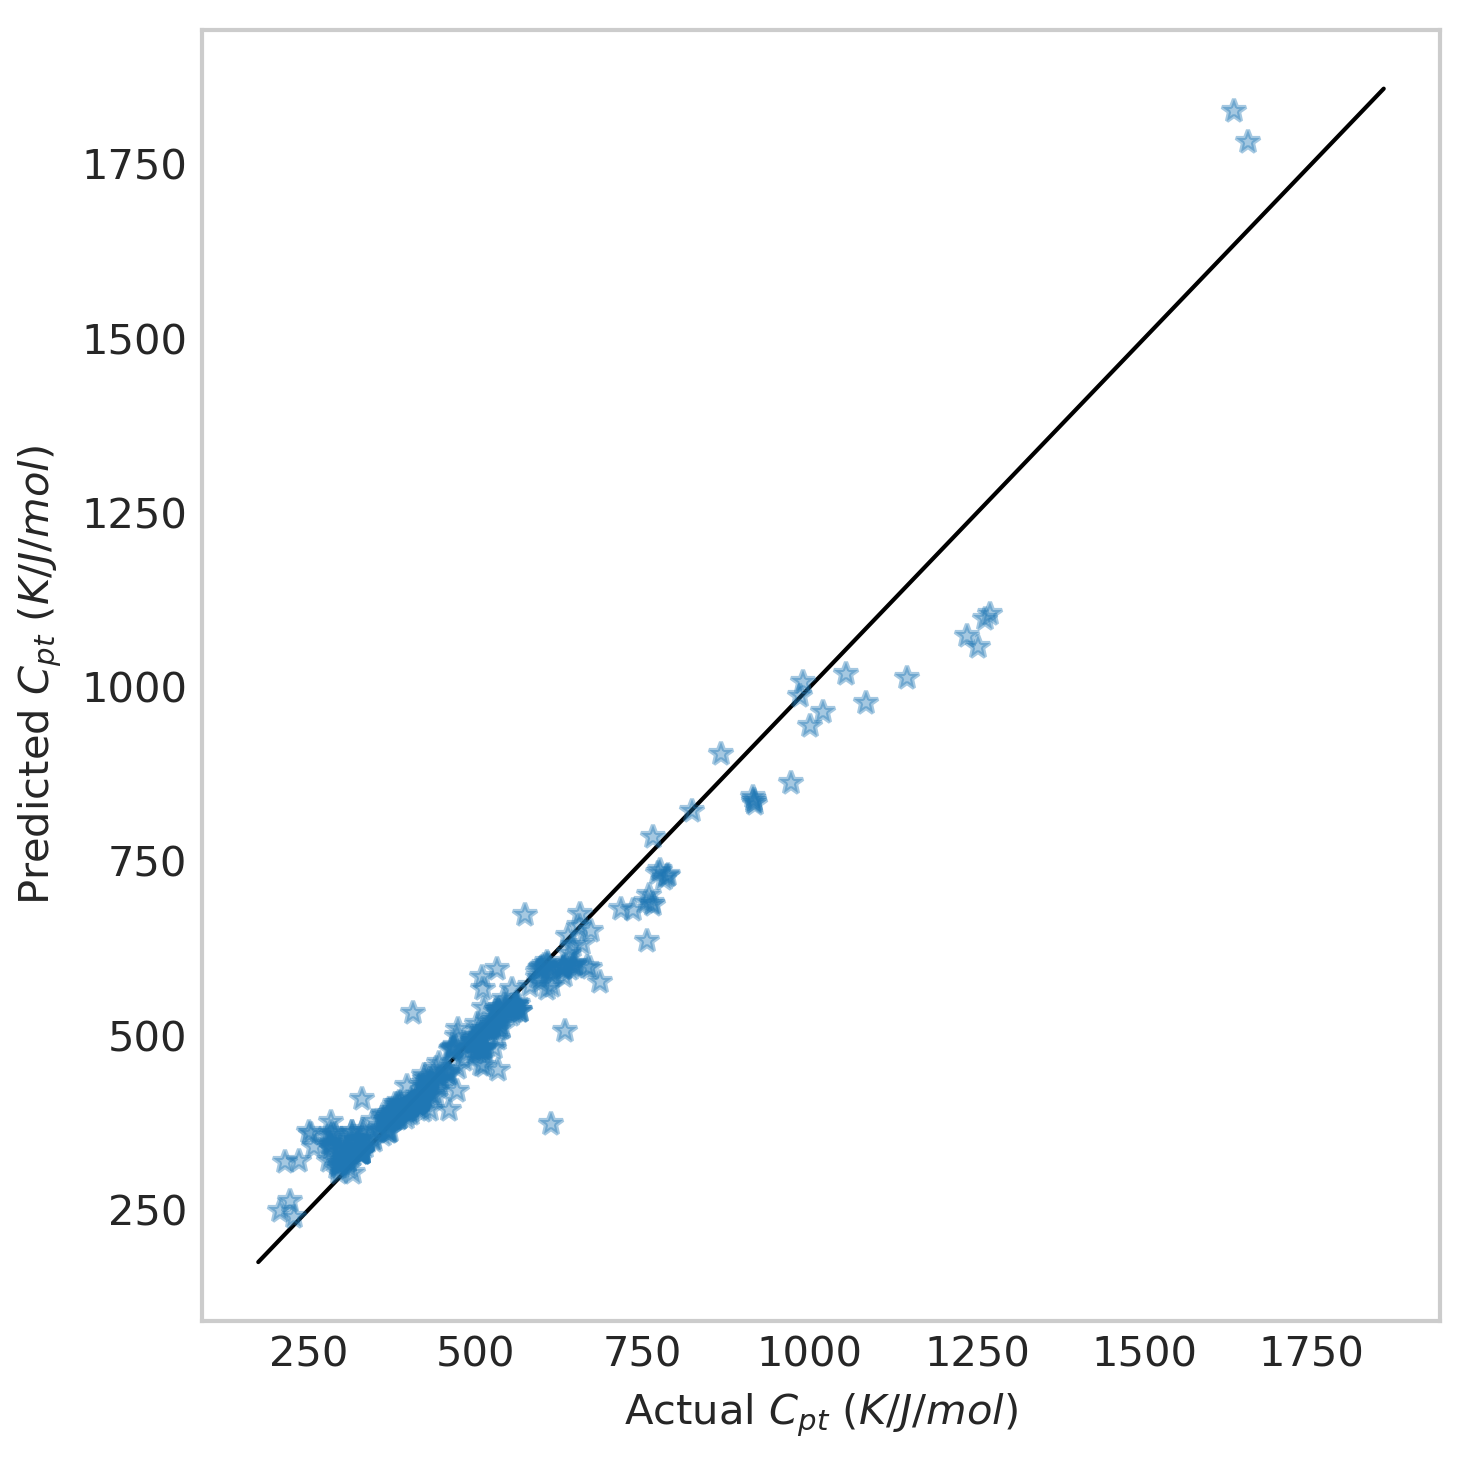

In [83]:
X=X_test
Y=Y_test
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    minval = np.min([np.exp(model.predict(X)[:]), np.exp(Y)[:]])
    maxval = np.max([np.exp(model.predict(X)[:]), np.exp(Y)[:]])
    buffer = (maxval - minval) / 100 * 2
    minval = minval - buffer
    maxval = maxval + buffer
    ax.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:],np.exp(model.predict(X))[:],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Predicted $C_{pt}$ $(K/J/mol)$")
    ax.set_xlabel("Actual $C_{pt}$ $(K/J/mol)$")
    ax.grid()
    plt.tight_layout()

In [84]:
# to load models as fitness criteria for the GAINS module
# they can be saved like so:
def save_model(name, model, devmodel, path=None):
    if path:
        model.save("{}{}_qspr.h5".format(path, name))
        devmodel.Data_summary.to_csv("{}{}_summ.csv".format(path, name))
        devmodel.Coef_data.to_csv("{}{}_desc.csv".format(path, name), index=False)
    else:
        model.save("{}_qspr.h5".format(name))
        devmodel.Data_summary.to_csv("{}_summ.csv".format(name))
        devmodel.Coef_data.to_csv("{}_desc.csv".format(name), index=False)

We can also load the QSPR/NN models used in the paper directly:

In [85]:
import gains as genetic
from numpy import array
def load_salty_models(model_ID, path=None):
    for i, name in enumerate(model_ID):
        if path:
            model = np.array([load_model(join(path,
                                              '{}_qspr.h5'.format(name)))])
            with open(join(path, '{}_desc.csv'.format(name)),
                      'rb') as csv_file:
                deslist = list([pd.read_csv(csv_file, encoding='latin1')])
            with open(join(path, '{}_summ.csv'.format(name)),
                      'rb') as csv_file:
                summary = pd.read_csv(csv_file, encoding='latin1')
        else:
            model = np.array([genetic.load_data("{}_qspr.h5".format(name),
                                                h5File=True)])
            deslist = list([genetic.load_data("{}_desc.csv".format(name))])
            summary = genetic.load_data("{}_summ.csv".format(name))
        parents = eval(summary.iloc[1][1])
        anions = eval(summary.iloc[2][1])
        if i > 0:
            parent_candidates = np.concatenate((parents, parent_candidates))
            anion_candidates = np.concatenate((anions, anion_candidates))
            models = np.concatenate((models, model))
            deslists = list([deslists, deslist])
        else:
            parent_candidates = parents
            anion_candidates = anions
            models = model
            deslists = deslist
    return parent_candidates, anion_candidates, models, deslists, summary

In [77]:
model_ID = ['density', 'cpt']
parent_candidates, anion_candidates, models, deslists, summary = load_salty_models(model_ID)

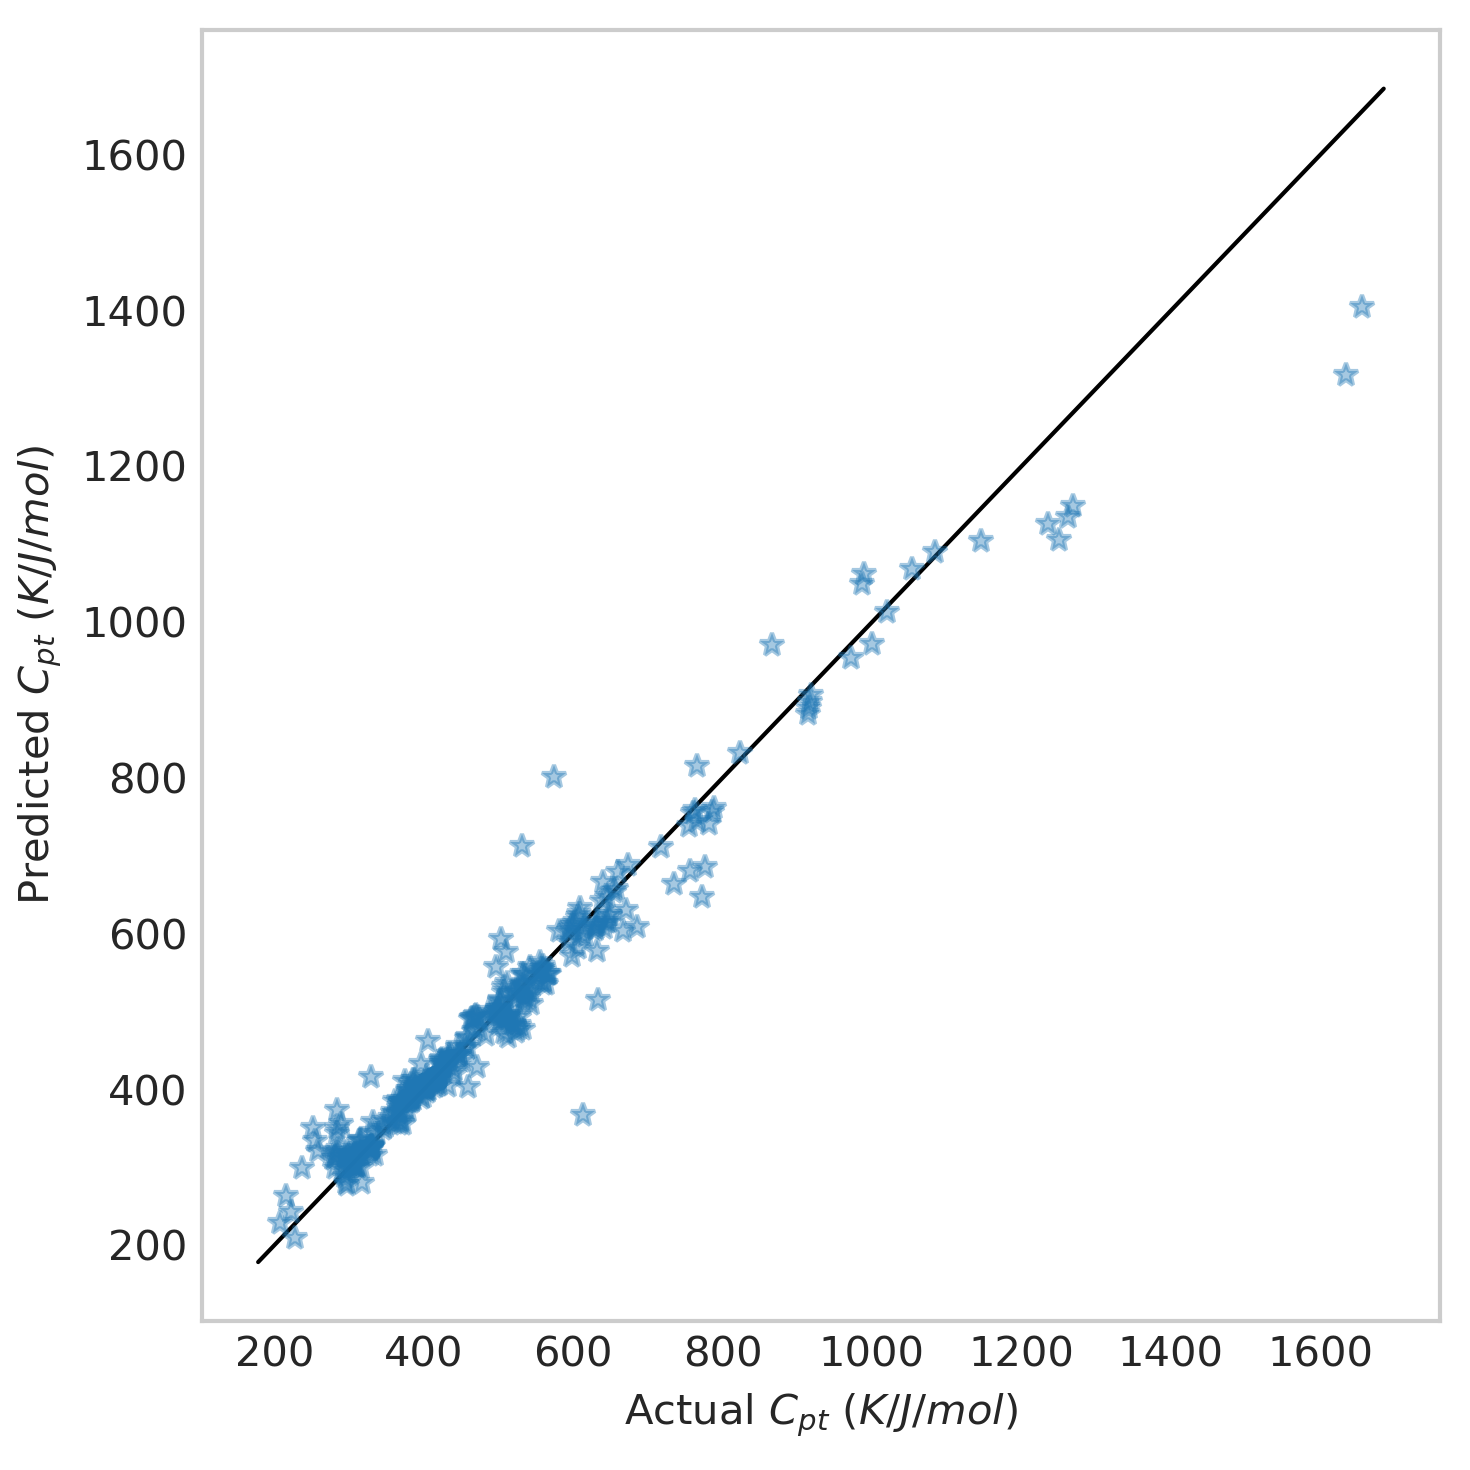

In [86]:
X=X_test
Y=Y_test
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    minval = np.min([np.exp(models[1].predict(X)[:]), np.exp(Y)[:]])
    maxval = np.max([np.exp(models[1].predict(X)[:]), np.exp(Y)[:]])
    buffer = (maxval - minval) / 100 * 2
    minval = minval - buffer
    maxval = maxval + buffer
    ax.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:],np.exp(models[1].predict(X))[:],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Predicted $C_{pt}$ $(K/J/mol)$")
    ax.set_xlabel("Actual $C_{pt}$ $(K/J/mol)$")
    ax.grid()
    plt.tight_layout()

The same for density:

In [70]:
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
devmodel = salty.aggregate_data(['density'], T=T, P=P)
X_train, Y_train, X_test, Y_test = salty.devmodel_to_array\
    (devmodel, train_fraction=0.8)
devmodel.Data_summary

,0
Unique salts,461
Cations,"array(['CCCC[n+]1ccc(cc1)C', 'CCCn1cc[n+](c1C)..."
Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
Total datapoints,5631
density,871.3 - 1709.32
Temperature range (K),100.0 - 101.33
Pressure range (kPa),297.05 - 315.91


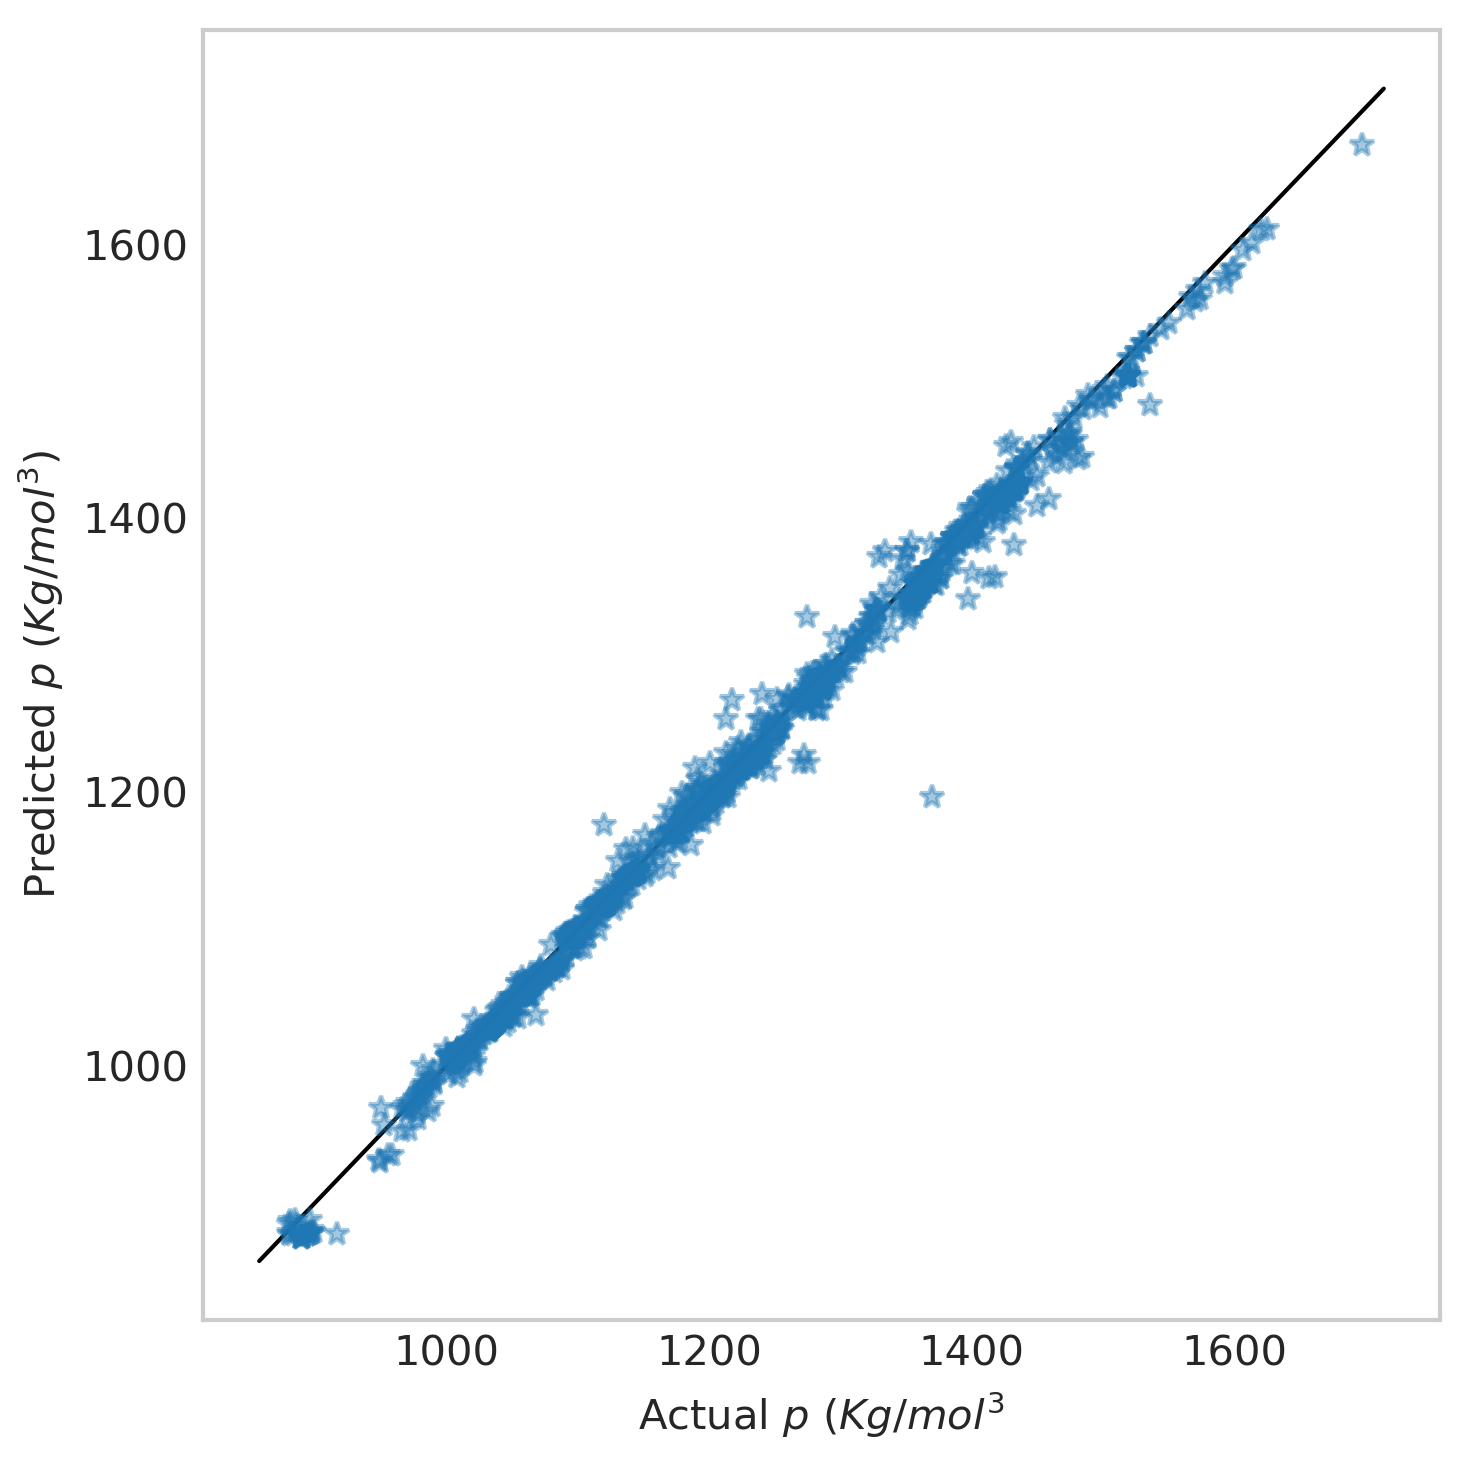

In [71]:

X=X_test
Y=Y_test
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    minval = np.min([np.exp(models[0].predict(X)[:]), np.exp(Y)[:]])
    maxval = np.max([np.exp(models[0].predict(X)[:]), np.exp(Y)[:]])
    buffer = (maxval - minval) / 100 * 2
    minval = minval - buffer
    maxval = maxval + buffer
    ax.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:],np.exp(models[0].predict(X))[:],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Predicted $p$ $(Kg/mol^3)$")
    ax.set_xlabel("Actual $p$ $(Kg/mol^3$")
    ax.grid()
    plt.tight_layout()